In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [148]:
pd.set_option('future.no_silent_downcasting', True)

In [149]:
df = pd.read_csv('bank_data.csv')

In [150]:
df['y'] = df['y'].replace({'no': 0, 'yes': 1})

In [151]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      
        self.threshold = threshold  
        self.left = left           
        self.right = right          
        self.value = value       

In [152]:
def fit(X, y):
    root = fit_tree(X, y)
    return root

def fit_tree(X, y, depth=0):
        rows, columns = X.shape
        num_samples_per_class = [np.sum(y == i) for i in range(num_classes)]
        most_common_class = np.argmax(num_samples_per_class)
        
        if len(np.unique(y)) == 1 or depth == max_depth:
            return Node(value=most_common_class)
        
        best_gain = -1
        best_feature = None
        best_threshold = None
        for feature_name in X.columns:
            feature_values = np.unique(X[feature_name])
            
            if len(feature_values) == 1: 
                continue
                
            for value in feature_values:
                left_indices = X.index[X[feature_name] == value]
                right_indices = X.index[X[feature_name] != value]
                left_entropy = calculate_entropy(y[left_indices])
                right_entropy = calculate_entropy(y[right_indices])
                entropy = (len(left_indices) / rows) * left_entropy + (len(right_indices) / rows) * right_entropy
                       
                gain = calculate_information_gain(calculate_entropy(y), entropy)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_name
                    best_threshold = value
        
        if best_gain == 0:  
            return Node(value=most_common_class)
        
        left_indices = X.index[X[best_feature] == best_threshold]
        right_indices = X.index[X[best_feature] != best_threshold]
        
        left_child = fit_tree(X.loc[left_indices], y.loc[left_indices], depth + 1)
        right_child = fit_tree(X.loc[right_indices], y.loc[right_indices], depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

def calculate_entropy(y):
    if len(y) == 0:
        return 0
    num_samples = len(y)
    num_samples_per_class = [np.sum(y == i) for i in range(num_classes)]
    class_probabilities = [num_samples_i / num_samples for num_samples_i in num_samples_per_class]
    entropy = -sum(p * np.log2(p) for p in class_probabilities if p != 0)
    return entropy

def calculate_information_gain(parent_entropy, children_entropy):
    return parent_entropy - children_entropy

def predict_X(root, X):
    return np.array([predict_x(x, root) for _, x in X.iterrows()])

def predict_x(x, node):
    if node.value is not None:
        return node.value
    if x[node.feature] == node.threshold:
        return predict_x(x, node.left)
    else:
        return predict_x(x, node.right)

In [153]:
def split_into_training_and_testing(X, y, test_size = 0.2, random_state = 42):
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    n_test_samples = int(test_size * n_samples)
    test_indices = indices[:n_test_samples]
    train_indices = indices[n_test_samples:]
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [154]:
def accuracy_score(y_pred, y_true):
    accuracy = len(y_pred)
    for i in range(len(y_pred)):
        if y_pred.iloc[i]!=y_true[i]:
            accuracy-=1
    return accuracy/len(y_pred)

In [155]:
X = df.drop(columns=['y']) 
y = df['y'] 

X_train, X_test, y_train, y_test = split_into_training_and_testing(X, y, test_size = 0.2, random_state = 1065)

In [156]:
heights = []
training_accuracies = []
testing_accuracies = []

for i in range(1, 5):

    heights.append(i)
    max_depth = i
    num_classes = len(np.unique(y_train))

    root = fit(X_train, y_train)
    
    y_pred_train = predict_X(root, X_train)
    training_accuracy = accuracy_score(y_train, y_pred_train)
    
    y_pred_test = predict_X(root, X_test)
    testing_accuracy = accuracy_score(y_test, y_pred_test)

    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)

In [157]:
def plot_training_and_test_accuracy(heights, training_accuracies, testing_accuracies):
    plt.plot(heights, training_accuracies, color='green', label='Training accuracy')
    plt.plot(heights, testing_accuracies, color='yellow', label='Testing accuracy')
    plt.xlabel('Height')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy score vs Height')
    plt.legend()
    plt.grid(True)
    plt.show()

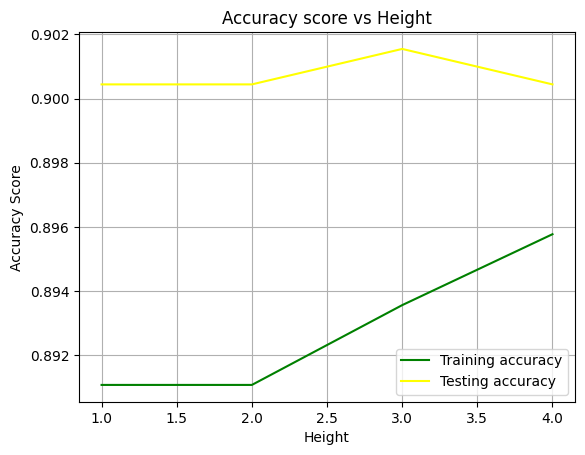

In [158]:
plot_training_and_test_accuracy(heights, training_accuracies, testing_accuracies)

In [159]:
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------

In [160]:
def fit_gradient_boosting_decision_trees(X, y, num_iterations, learning_rate):
    trees =[]
    residuals = y.copy()
    for _ in range(num_iterations):
        root = fit(X, residuals)
        predictions = predict_X(root, X)
        residuals -= learning_rate * predictions
        trees.append(root)
    return trees

def predict(X, trees, learning_rate):
    predictions = np.zeros(len(X))
    for root in trees:
        predictions += learning_rate * predict_X(root, X)
    proba = 1 / (1 + np.exp(-predictions))
    return (proba > 0.5).astype(int)

In [161]:
X = df.drop(columns=['y']) 
y = df['y'] 

X_train, X_test, y_train, y_test = split_into_training_and_testing(X, y, test_size = 0.2, random_state = 1065)

max_depth = 4
num_terations = 10
learning_rate = 0.1
trees = fit_gradient_boosting_decision_trees(X_train, y_train, num_terations, learning_rate)

y_pred_train = predict(X_train, trees, learning_rate)
training_accuracy = accuracy_score(y_train, y_pred_train)

y_pred_test = predict(X_test, trees, learning_rate)
testing_accuracy = accuracy_score(y_test, y_pred_test)

print(training_accuracy)
print(testing_accuracy)

0.8977052806192978
0.8904867256637168
